In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pathlib

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
%cd /content/gdrive/My Drive/

/content/gdrive/My Drive


In [5]:
path = r'/content/gdrive/MyDrive/PetImages'

In [6]:
img_height = 64
img_width = 64

batch_size = 32

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  seed=123,
  subset="training",
  validation_split = 0.2,
  shuffle = True,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 23439 files belonging to 2 classes.
Using 18752 files for training.


In [8]:
class_names = train_ds.class_names

In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  seed=123,
  validation_split = 0.2,
  subset="validation",
  image_size=(img_height, img_width), 
  batch_size=batch_size
)

Found 23439 files belonging to 2 classes.
Using 4687 files for validation.


In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)# work faster
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
def nn():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, kernel_size = (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(32, kernel_size = (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Dense(128, activation='sigmoid'),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    
    return model

In [12]:
model = nn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                        

In [13]:
lr = 0.001
optimizer = keras.optimizers.Adam(learning_rate = lr)

In [14]:
callback = tf.keras.callbacks.ModelCheckpoint('weights.h5', save_weights_only = True)

In [21]:
model.compile(
  loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer = optimizer,
  metrics = [keras.metrics.SparseCategoricalAccuracy()]
)

In [27]:
model.fit(
  x = train_ds,
  batch_size = batch_size,
  epochs=15,
  validation_data = val_ds,
  callbacks = [callback],
)

Epoch 1/15
586/586 [==============================] - 636s 1s/step - loss: 0.5623 - sparse_categorical_accuracy: 0.7066 - val_loss: 0.5895 - val_sparse_categorical_accuracy: 0.7256
Epoch 2/15
586/586 [==============================] - 125s 213ms/step - loss: 0.4360 - sparse_categorical_accuracy: 0.8003 - val_loss: 0.3954 - val_sparse_categorical_accuracy: 0.8214
Epoch 3/15
586/586 [==============================] - 125s 213ms/step - loss: 0.3599 - sparse_categorical_accuracy: 0.8388 - val_loss: 0.4206 - val_sparse_categorical_accuracy: 0.7992
Epoch 4/15
586/586 [==============================] - 125s 213ms/step - loss: 0.2959 - sparse_categorical_accuracy: 0.8719 - val_loss: 0.4074 - val_sparse_categorical_accuracy: 0.8334
Epoch 5/15
586/586 [==============================] - 124s 212ms/step - loss: 0.2424 - sparse_categorical_accuracy: 0.8979 - val_loss: 0.4187 - val_sparse_categorical_accuracy: 0.8244
Epoch 6/15
586/586 [==============================] - 124s 212ms/step - loss: 0.196

In [40]:
model.save('CNN_cat_dog_tf.model')

In [45]:
model.load_weights('weights.h5')

In [47]:
model = tf.keras.models.load_model("CNN_cat_dog_tf.model")

In [30]:
import matplotlib.pyplot as plt

In [44]:
def show(p, name = '', prediction = ''):
  image = plt.imread(p)
  plt.imshow(image)

  plt.title(f'{name} {prediction}')
  plt.axis(False)


In [33]:
p = f'{path}/Dog/11701.jpg'

In [ ]:
show(p)

In [48]:
img = tf.keras.utils.load_img(
    p,
    target_size=(img_height, img_width)
)

input_arr = tf.keras.preprocessing.image.img_to_array(img)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)
predictions[0]


1/1 [==============================] - 0s 469ms/step


array([0.00538155, 0.9946185 ], dtype=float32)

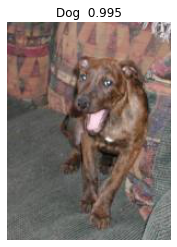

In [49]:
i=np.where(predictions[0] == max(predictions[0]))[0][0]
show(p, class_names[i], f'{predictions[0][i] : .3f}')